### place the data from Kaist in this folder, 

In [1]:
!unzip -q set05.zip
# !unzip -q ./drive/MyDrive/acv_project/weights.zip

unzip:  cannot find or open set05.zip, set05.zip.zip or set05.zip.ZIP.


In [2]:
!git clone https://github.com/joehoeller/Object-Detection-on-Thermal-Images

Cloning into 'Object-Detection-on-Thermal-Images'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 233 (delta 10), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (233/233), 12.55 MiB | 36.10 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [1]:
# from models import *
import numpy as np
from scipy.io import loadmat as import_mat
from matplotlib import pyplot as plt
from matplotlib.cm import viridis as cm_viridis
import torch
from glob import glob
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
from datetime import datetime
from PIL import Image
from collections import defaultdict
import torch
import argparse
from importlib import reload
from torch.nn.utils import clip_grad_norm_

In [3]:
class BrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_files):
        self.files = input_files
        


        self.target = transforms.Compose([transforms.Resize(256),
                                          transforms.ToTensor(),
                                          ])
        
        self.inpt = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor()])
        
        self.annotation = lambda x : x.replace("lwir", "visible")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        # inpt = self.inpt(Image.open(self.files[index]))
        target = Image.open(self.annotation(self.files[index]))
        grayscale = target.convert("LA")
        target = self.target(target)
                  
        return {
            "input" : self.target(grayscale)[:1],
            "target" : (target - 0.5)/0.5,
        }

dataset = glob("./lwir/*.jpg")

train_dataset = BrainDataset(dataset[:int(0.7*len(dataset))])
val_dataset = BrainDataset(dataset[int(len(dataset)*0.7):])

train_sampler = torch.utils.data.DataLoader(train_dataset,num_workers=32, pin_memory=True, batch_size=16, shuffle=True)
val_sampler = torch.utils.data.DataLoader(val_dataset, num_workers=32, pin_memory=True, batch_size=16, shuffle=True)

In [4]:
class pixelcolor(torch.nn.Module):
    
    def __init__(self):
        super(pixelcolor, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.decoder = torch.nn.Sequential(
                torch.nn.BatchNorm2d(num_features=128),
                torch.nn.LeakyReLU(),
                torch.nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0),
                torch.nn.BatchNorm2d(num_features=256),
                torch.nn.LeakyReLU(),
                torch.nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(num_features=256),
                torch.nn.LeakyReLU(),
                torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(num_features=128),
                torch.nn.LeakyReLU(),
                torch.nn.ConvTranspose2d(in_channels=128, out_channels=100, kernel_size=2, stride=1, padding=1))


        self.model = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=0),
                torch.nn.BatchNorm2d(num_features=64),
                torch.nn.LeakyReLU(),
                torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0),
                torch.nn.BatchNorm2d(num_features=128),
                torch.nn.LeakyReLU(),
                torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0),
                torch.nn.BatchNorm2d(num_features=256),
                torch.nn.LeakyReLU(),
                torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2, stride=1, padding=1))
    
    def forward(self, x ):
        encoded_output = self.model(x)
        
        return self.decoder(encoded_output)


In [5]:
nnn = pixelcolor()

In [6]:
nn = nnn.to(nnn.device)

In [7]:
nn(torch.randn([1, 1, 128, 128]).to(nnn.device)).shape

torch.Size([1, 100, 128, 128])

In [ ]:
nn.load_state_dict(torch.load("./model.pt"))

<All keys matched successfully>

## training

In [2]:
def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))

softplus = torch.nn.Softplus()
def discretized_mix_logistic_loss(l, x):
    # from https://github.com/pclucas14/pixel-cnn-pp
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10) 
    # print(ls, nr_mix)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = torch.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + torch.autograd.Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = torch.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = torch.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

NameError: name 'torch' is not defined

In [9]:
import torch.optim as optim

# criterion = torch.nn.MSELoss()
criterion = discretized_mix_logistic_loss
optimizer = optim.Adam(nn.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=185, gamma=0.7)

In [10]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

task_type = "image_translation_logistic"
time_date = "{}".format(datetime.now())
tensorboard_writer = SummaryWriter("../drive/MyDrive/acv_project/log/{}/{}".format(task_type, time_date))

In [11]:
epoch = 0

In [12]:
plots = []
running_loss = 0.
controller = tqdm(total=int(len(train_dataset) * (40-epoch)/16))

best_val_loss = 0
while epoch < 40:
    train_loss = []
    train_acc = []
    for each_batch_sample in train_sampler:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nn(each_batch_sample['input'].to(nn.device))
        CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
        loss = criterion(outputs, CbCr_target)

        loss.backward()
        
        clip_grad_norm_(nn.parameters(), 2)
        optimizer.step()
        scheduler.step()
        
        
        running_loss += loss.item()
        controller.update(1)
        controller.set_postfix({"loss":running_loss/controller.n})
        train_loss.append(loss.item())
        
        # acc = np.count_nonzero(outputs.argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())/np.prod(CbCr_target.shape)
        # train_acc.append(acc)
        
        
        tensorboard_writer.add_scalar("loss/batch/train", loss.item(), controller.n)
        # tensorboard_writer.add_scalar("acc/batch/train", acc, controller.n)
        
    
        
    tensorboard_writer.add_scalar("loss/epoch/train", np.mean(train_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/train", np.mean(train_acc), epoch)

    with torch.no_grad():
        val_loss = []
        val_acc = []
        for each_batch_sample in val_sampler:
            outputs = nn(each_batch_sample['input'].to(nn.device))
            CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
            loss = criterion(outputs, CbCr_target)
            # acc = np.count_nonzero(outputs.argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())
            # val_acc.append(acc/np.prod(CbCr_target.shape))
            val_loss.append(loss.item())
            
    tensorboard_writer.add_scalar("loss/epoch/val", np.mean(val_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/val", np.mean(val_acc), epoch)
    
    torch.save(nn.state_dict(), "../drive/MyDrive/acv_project/weights/logistic_{}_{}".format(task_type, epoch))
    
    epoch += 1
    print("Epoch {}, Train Loss {}, Val Loss {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1, Train Loss 15730184.96875, Val Loss 14767716.745454546
Epoch 2, Train Loss 14716590.3984375, Val Loss 14316254.38181818
Epoch 3, Train Loss 14426423.328125, Val Loss 14206979.563636364
Epoch 4, Train Loss 13987151.46875, Val Loss 14422782.0
Epoch 5, Train Loss 13960148.3359375, Val Loss 13861808.581818182
Epoch 6, Train Loss 13791595.9765625, Val Loss 13781822.454545455
Epoch 7, Train Loss 13563655.09375, Val Loss 13587785.927272728
Epoch 8, Train Loss 13415921.9609375, Val Loss 13930058.236363636
Epoch 9, Train Loss 13420565.8515625, Val Loss 13310401.963636363
Epoch 10, Train Loss 13328048.4609375, Val Loss 13166577.345454546
Epoch 11, Train Loss 13113173.7890625, Val Loss 13190800.963636363
Epoch 12, Train Loss 13097198.375, Val Loss 13165190.163636364
Epoch 13, Train Loss 12955340.0859375, Val Loss 12999005.527272727
Epoch 14, Train Loss 13123204.6796875, Val Loss 12892401.4
Epoch 15, Train Loss 13020515.7109375, Val Loss 13027793.672727272
Epoch 16, Train Loss 12809699.75

KeyboardInterrupt: ignored

## Evaluation

In [54]:
for each_batch_sample in val_sampler:
    outputs = nn(each_batch_sample['input'].to(nn.device))
    CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
    sddsds

NameError: ignored

In [55]:
inp = np.array(each_batch_sample['input']).transpose([0, 2, 3, 1])
target = np.array(each_batch_sample['target']).transpose([0, 2, 3, 1])
output = np.array(sample_from_discretized_mix_logistic(outputs, 10).detach().cpu()).transpose([0, 2, 3, 1])

In [60]:
random = np.random.randint(len(inp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 255.5, -0.5)

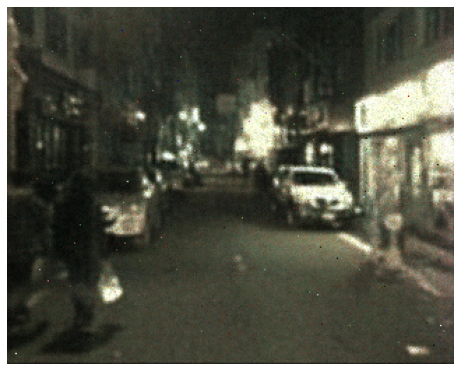

In [61]:
plt.figure(figsize=(8, 8))
plt.imshow(((output[random]*0.5+0.5)*256).astype(int))
plt.axis("off")

(-0.5, 319.5, 255.5, -0.5)

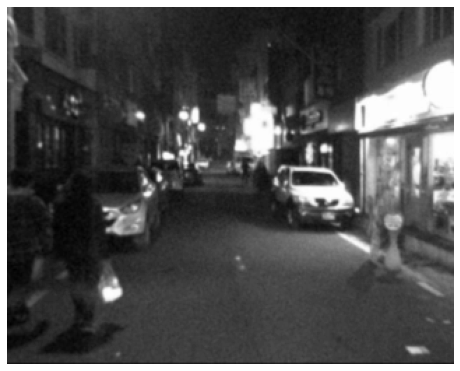

In [62]:
plt.figure(figsize=(8, 8))
plt.imshow(((inp[random][:, :, 0]*0.5+0.5)*256).astype(int), cmap="gray")
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 255.5, -0.5)

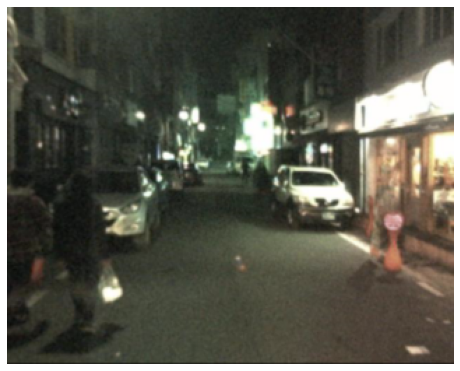

In [63]:
plt.figure(figsize=(8, 8))
plt.imshow(((target[random]*0.5+0.5)*256).astype(int))
plt.axis("off")

In [36]:
((output[random]+1).max()*128).astype(int).shape

()

In [28]:
target.max()

1.0

In [44]:
Image.fromarray(((output[random]+1)*128).astype(int))

TypeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


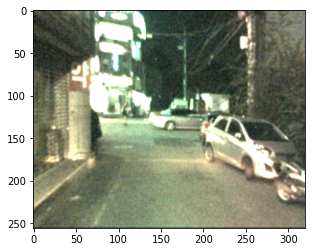

In [19]:
plt.imshow(target[random]+1)

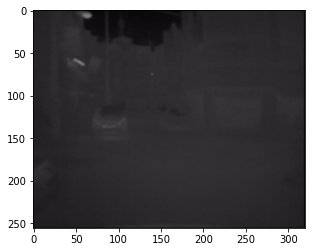

In [20]:
plt.imshow(inp[random])

In [ ]:
target[random].min()

-0.9137255

In [ ]:
def sample_from_discretized_mix_logistic_1d(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [1] #[3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # for mean, scale

    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    out = x0.unsqueeze(1)
    return out

In [15]:
def to_one_hot(tensor, n, fill_with=1.):
    # we perform one hot encore with respect to the last axis
    one_hot = torch.FloatTensor(tensor.size() + (n,)).zero_()
    if tensor.is_cuda : one_hot = one_hot.cuda()
    one_hot.scatter_(len(tensor.size()), tensor.unsqueeze(-1), fill_with)
    return torch.autograd.Variable(one_hot)


def sample_from_discretized_mix_logistic(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3])
    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    coeffs = torch.sum(torch.tanh(
        l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, dim=4)
    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = torch.autograd.Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    x1 = torch.clamp(torch.clamp(
       x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, min=-1.), max=1.)
    x2 = torch.clamp(torch.clamp(
       x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, min=-1.), max=1.)

    out = torch.cat([x0.view(xs[:-1] + [1]), x1.view(xs[:-1] + [1]), x2.view(xs[:-1] + [1])], dim=3)
    # put back in Pytorch ordering
    out = out.permute(0, 3, 1, 2)
    return out